In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

env = gym.make('Asterix-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print(env.action_space)
print(env.observation_space)
print(device)


import warnings
warnings.filterwarnings('ignore')

#Code is inspired from Pytorch tutorial

Discrete(9)
Box(210, 160, 3)
cuda


<h3>Preprocess frames</h3>

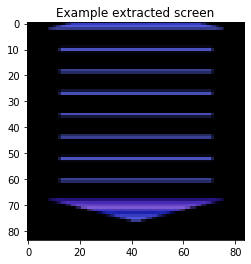

torch.Size([1, 3, 84, 84])


In [2]:
resize = T.Compose([T.ToPILImage(), T.Resize(84, interpolation=Image.CUBIC), T.ToTensor()])

def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = screen[:, 20:180]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

print(get_screen().shape)

<h3>Experience Replay Buffer </h3>

In [3]:
# Transisition tuple to store
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

<h3>NETWORK</h3>

In [4]:
class Neural_Network(nn.Module):

    def __init__(self, h, w, outputs):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(64)
        
        def conv2d_size_out(size, kernel_size = 4, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w, 5, 2), 5, 2), 5, 2)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h, 5, 2), 5, 2), 5, 2)
        
        self.head = nn.Linear(convw*convh*64, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

    

In [5]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

policy_net = Neural_Network(screen_height, screen_width, n_actions).to(device)
target_net = Neural_Network(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(9)]], device=device, dtype=torch.long)


<h3>DDQN update</h3>

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)


    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    next_state_values[non_final_mask] = target_net(non_final_next_states)[range(non_final_next_states.size(0)),policy_net(non_final_next_states).max(1)[1]].detach()
#     maxAction = policy_net(non_final_next_states)[0].detach().argmax()
#     next_state_values[non_final_mask] = target_net(non_final_next_states)[0][maxAction].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
num_episodes = 1000
total_rewards = []
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    r = 0
    for t in count():
        # Select and perform an action
        action = select_action(state)
#         print(action)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        r += reward.item()
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    total_rewards.append(r)


print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

# print(total_rewards)


<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>

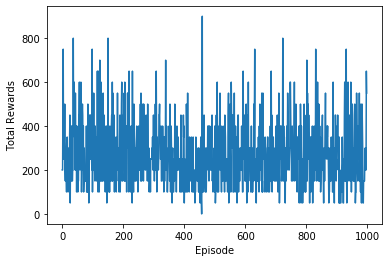

In [9]:
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
# plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])
plt.plot([np.mean(total_rewards[tr:tr+1]) for tr in range(1, len(total_rewards))])

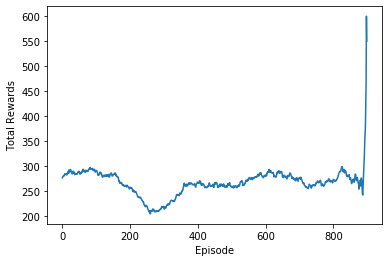

In [10]:
window = 100
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])